# Model Evaluation and Error Analysis

This notebook covers:
1. Comprehensive model evaluation on test set
2. ROC and Precision-Recall curves
3. Confusion matrix analysis
4. Cost-based analysis
5. Error analysis with case studies
6. False positive and false negative analysis


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                            roc_auc_score, average_precision_score,
                            confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve,
                            accuracy_score)
import joblib

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed for reproducibility
np.random.seed(42)


## 1. Load Data and Model


In [2]:
# Load processed features and test set indices
data_path = Path('../data')
models_path = Path('../data/models')

features_df = pd.read_csv(data_path / 'provider_level_features.csv')
test_indices = pd.read_csv(models_path / 'test_indices.csv', header=None)[0].values

# Load best model and scaler
best_model = joblib.load(models_path / 'best_model.pkl')
scaler = joblib.load(models_path / 'scaler.pkl')
model_comparison = pd.read_csv(models_path / 'model_comparison.csv')

print("=" * 60)
print("LOADED DATA AND MODEL")
print("=" * 60)
print(f"Features dataframe shape: {features_df.shape}")
print(f"Test set size: {len(test_indices)}")
print(f"\nBest model: {model_comparison.loc[model_comparison['PR-AUC'].idxmax(), 'Model']}")


LOADED DATA AND MODEL
Features dataframe shape: (5410, 134)
Test set size: 1083

Best model: XGBoost (Tuned)


In [3]:
# Prepare test set
feature_cols = [col for col in features_df.columns 
                if col not in ['Provider', 'PotentialFraud', 'Target']]

# Split into train/val (will be combined) and test
X_test = features_df.loc[test_indices, feature_cols].copy()
y_test = features_df.loc[test_indices, 'Target'].copy()
test_providers = features_df.loc[test_indices, 'Provider'].copy()

print(f"Test set shape: {X_test.shape}")
print(f"\nTest set target distribution:")
print(y_test.value_counts())
print(f"\nFraud rate in test set: {y_test.mean() * 100:.2f}%")


Test set shape: (1083, 131)

Test set target distribution:
Target
0    982
1    101
Name: count, dtype: int64

Fraud rate in test set: 9.33%


## 2. Make Predictions on Test Set


In [4]:
# Check if model needs scaled features
model_name = model_comparison.loc[model_comparison['PR-AUC'].idxmax(), 'Model']

if 'Logistic Regression' in model_name or 'SVM' in model_name:
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Predictions with default threshold (0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Predictions generated!")
print(f"Predicted fraud rate: {y_pred.mean() * 100:.2f}%")
print(f"Actual fraud rate: {y_test.mean() * 100:.2f}%")


Predictions generated!
Predicted fraud rate: 10.71%
Actual fraud rate: 9.33%


## 3. Comprehensive Evaluation Metrics


In [5]:
# Calculate all evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print("=" * 60)
print("COMPREHENSIVE EVALUATION METRICS - TEST SET")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print(f"\nConfusion Matrix:")
print(f"              Predicted")
print(f"              No    Yes")
print(f"Actual No   {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"      Yes   {cm[1,0]:5d}  {cm[1,1]:5d}")

# Calculate rates
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Breakdown:")
print(f"True Negatives (TN):  {tn:5d} - Correctly identified legitimate providers")
print(f"False Positives (FP): {fp:5d} - Legitimate providers flagged as fraud")
print(f"False Negatives (FN): {fn:5d} - Fraudulent providers missed")
print(f"True Positives (TP):  {tp:5d} - Correctly identified fraudulent providers")


COMPREHENSIVE EVALUATION METRICS - TEST SET
Accuracy:  0.9363
Precision: 0.6379
Recall:    0.7327
F1-Score:  0.6820
ROC-AUC:   0.9679
PR-AUC:    0.7989

Confusion Matrix:
              Predicted
              No    Yes
Actual No     940     42
      Yes      27     74

Detailed Breakdown:
True Negatives (TN):    940 - Correctly identified legitimate providers
False Positives (FP):    42 - Legitimate providers flagged as fraud
False Negatives (FN):    27 - Fraudulent providers missed
True Positives (TP):     74 - Correctly identified fraudulent providers


## 4. Visualization: Confusion Matrix


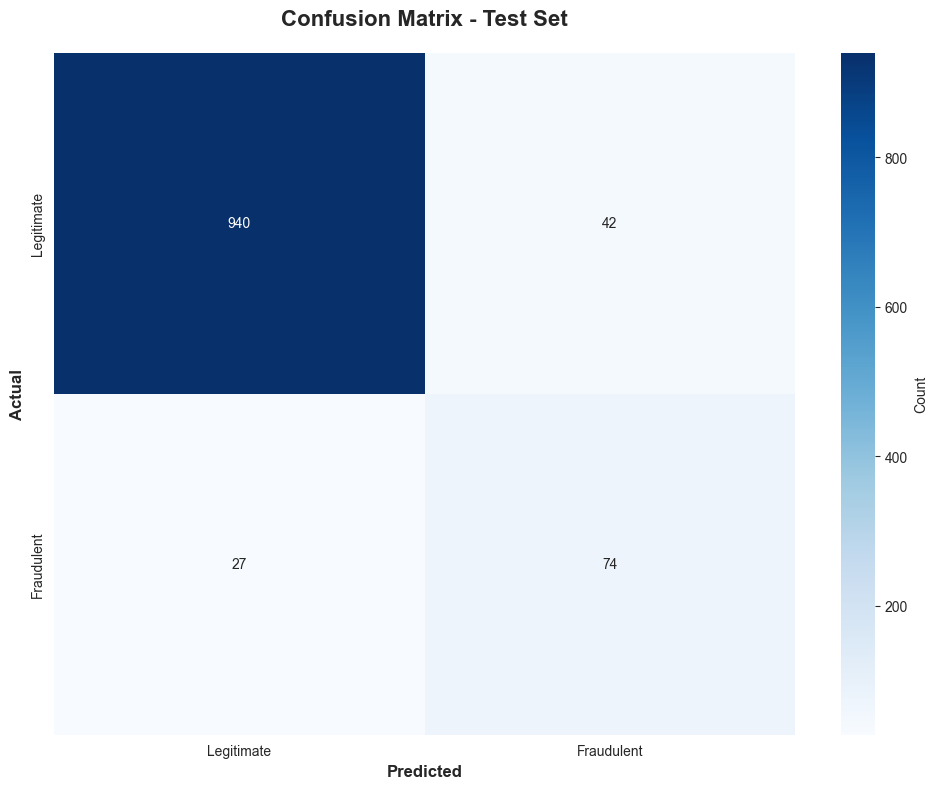

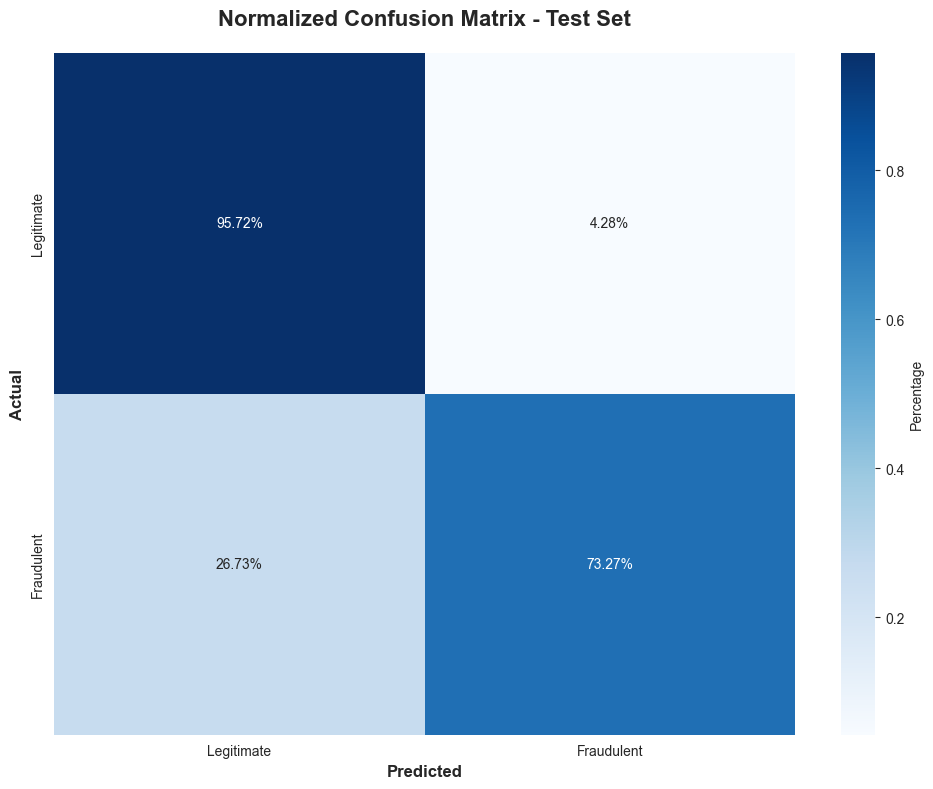

In [6]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Legitimate', 'Fraudulent'],
           yticklabels=['Legitimate', 'Fraudulent'],
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=['Legitimate', 'Fraudulent'],
           yticklabels=['Legitimate', 'Fraudulent'],
           cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. ROC Curve and Precision-Recall Curve


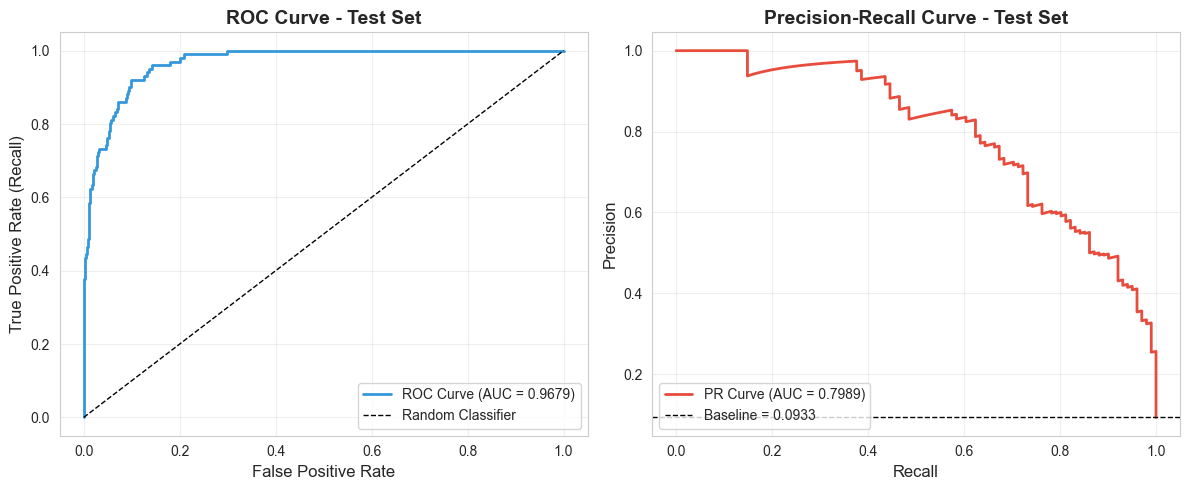

In [7]:
# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

# Calculate Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2, color='#3498db')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {pr_auc:.4f})', 
        linewidth=2, color='#e74c3c')
baseline = y_test.mean()
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline = {baseline:.4f}', linewidth=1)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Cost-Based Analysis

Understanding the business impact of false positives and false negatives is crucial for fraud detection.


In [8]:
# Cost-based analysis
# Define cost assumptions (these are estimates - adjust based on business requirements)
COST_FP = 1000  # Cost of investigating a false positive (investigation time, reputation damage)
COST_FN = 50000  # Cost of missing a fraudulent provider (financial loss, patient harm)

print("=" * 60)
print("COST-BASED ANALYSIS")
print("=" * 60)

total_cost = (fp * COST_FP) + (fn * COST_FN)
cost_with_perfect_model = 0  # Perfect model has no errors
cost_with_all_legitimate = fn * COST_FN  # If we predict all as legitimate
cost_with_all_fraud = fp * COST_FP  # If we predict all as fraud

print(f"\nCost Assumptions:")
print(f"  False Positive Cost: ${COST_FP:,} (investigation cost)")
print(f"  False Negative Cost: ${COST_FN:,} (missed fraud cost)")

print(f"\nActual Costs:")
print(f"  Total Cost: ${total_cost:,}")
print(f"    - From False Positives: ${fp * COST_FP:,} ({fp} × ${COST_FP:,})")
print(f"    - From False Negatives: ${fn * COST_FN:,} ({fn} × ${COST_FN:,})")

print(f"\nComparison Scenarios:")
print(f"  Perfect Model Cost: ${cost_with_perfect_model:,}")
print(f"  All Legitimate Cost: ${cost_with_all_legitimate:,}")
print(f"  All Fraud Cost: ${cost_with_all_fraud:,}")

cost_savings_vs_all_legitimate = cost_with_all_legitimate - total_cost
cost_savings_percentage = (cost_savings_vs_all_legitimate / cost_with_all_legitimate) * 100

print(f"\nModel Performance:")
print(f"  Cost Savings vs. Predicting All Legitimate: ${cost_savings_vs_all_legitimate:,}")
print(f"  Cost Savings Percentage: {cost_savings_percentage:.2f}%")


COST-BASED ANALYSIS

Cost Assumptions:
  False Positive Cost: $1,000 (investigation cost)
  False Negative Cost: $50,000 (missed fraud cost)

Actual Costs:
  Total Cost: $1,392,000
    - From False Positives: $42,000 (42 × $1,000)
    - From False Negatives: $1,350,000 (27 × $50,000)

Comparison Scenarios:
  Perfect Model Cost: $0
  All Legitimate Cost: $1,350,000
  All Fraud Cost: $42,000

Model Performance:
  Cost Savings vs. Predicting All Legitimate: $-42,000
  Cost Savings Percentage: -3.11%


## 7. Error Analysis

We'll analyze false positives and false negatives to understand model limitations and identify patterns.


In [9]:
# Create dataframe with predictions and probabilities
results_df = pd.DataFrame({
    'Provider': test_providers.values,
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})

# Identify errors
results_df['Error_Type'] = 'Correct'
results_df.loc[(results_df['Actual'] == 0) & (results_df['Predicted'] == 1), 'Error_Type'] = 'False Positive'
results_df.loc[(results_df['Actual'] == 1) & (results_df['Predicted'] == 0), 'Error_Type'] = 'False Negative'
results_df.loc[(results_df['Actual'] == 1) & (results_df['Predicted'] == 1), 'Error_Type'] = 'True Positive'
results_df.loc[(results_df['Actual'] == 0) & (results_df['Predicted'] == 0), 'Error_Type'] = 'True Negative'

# Add feature values for analysis
feature_data = X_test.copy()
feature_data['Provider'] = test_providers.values
results_df = results_df.merge(feature_data, on='Provider', how='left')

print("=" * 60)
print("ERROR ANALYSIS OVERVIEW")
print("=" * 60)
print(f"\nError distribution:")
print(results_df['Error_Type'].value_counts())
print(f"\nError rates:")
print(f"  False Positive Rate: {fp / (fp + tn) * 100:.2f}%")
print(f"  False Negative Rate: {fn / (fn + tp) * 100:.2f}%")


ERROR ANALYSIS OVERVIEW

Error distribution:
Error_Type
True Negative     940
True Positive      74
False Positive     42
False Negative     27
Name: count, dtype: int64

Error rates:
  False Positive Rate: 4.28%
  False Negative Rate: 26.73%


### 7.1 False Positive Analysis

False positives are legitimate providers incorrectly flagged as fraudulent. This can lead to unnecessary investigations and reputational damage.


In [10]:
# Analyze false positives
false_positives = results_df[results_df['Error_Type'] == 'False Positive'].copy()

print(f"Total False Positives: {len(false_positives)}")
print(f"\nFalse Positive Statistics:")

if len(false_positives) > 0:
    # Compare false positives with correctly classified legitimate providers
    true_negatives = results_df[results_df['Error_Type'] == 'True Negative'].copy()
    
    # Analyze key features
    key_features = [col for col in feature_cols if any(term in col.lower() for term in 
                   ['count', 'sum', 'mean', 'unique', 'ratio'])][:10]
    
    print("\nAverage feature values comparison:")
    comparison = pd.DataFrame({
        'False Positives': false_positives[key_features].mean(),
        'True Negatives': true_negatives[key_features].mean() if len(true_negatives) > 0 else 0
    })
    comparison['Difference'] = comparison['False Positives'] - comparison['True Negatives']
    comparison = comparison.sort_values('Difference', ascending=False, key=abs)
    
    print(comparison.head(10))
    
    print(f"\nFalse Positive Probability Statistics:")
    print(f"  Mean probability: {false_positives['Probability'].mean():.4f}")
    print(f"  Median probability: {false_positives['Probability'].median():.4f}")
    print(f"  Min probability: {false_positives['Probability'].min():.4f}")
    print(f"  Max probability: {false_positives['Probability'].max():.4f}")


Total False Positives: 42

False Positive Statistics:

Average feature values comparison:
                                       False Positives  True Negatives  \
Inpatient_InscClaimAmtReimbursed_sum     311442.619048    22013.936170   
Inpatient_DeductibleAmtPaid_sum           31836.571429     2317.787234   
Inpatient_InscClaimAmtReimbursed_mean     10355.638574     9798.215597   
Inpatient_ClaimCount                         30.642857        2.214894   
Inpatient_Unique_ClaimID                     30.642857        2.214894   
Inpatient_Unique_ClaimEndDt                  28.309524        2.162766   
Inpatient_Unique_ClaimStartDt                28.261905        2.173404   
Inpatient_UniqueBeneficiaries                27.738095        2.108511   
Inpatient_LOS_mean                            6.469363        5.424091   
Inpatient_DeductibleAmtPaid_mean           1068.000000     1068.000000   

                                          Difference  
Inpatient_InscClaimAmtReimbursed_sum   2

### 7.2 False Negative Analysis

False negatives are fraudulent providers that the model missed. These are critical errors as they allow fraud to continue.


In [11]:
# Analyze false negatives
false_negatives = results_df[results_df['Error_Type'] == 'False Negative'].copy()

print(f"Total False Negatives: {len(false_negatives)}")
print(f"\nFalse Negative Statistics:")

if len(false_negatives) > 0:
    # Compare false negatives with correctly classified fraudulent providers
    true_positives = results_df[results_df['Error_Type'] == 'True Positive'].copy()
    
    # Analyze key features
    key_features = [col for col in feature_cols if any(term in col.lower() for term in 
                   ['count', 'sum', 'mean', 'unique', 'ratio'])][:10]
    
    print("\nAverage feature values comparison:")
    comparison = pd.DataFrame({
        'False Negatives': false_negatives[key_features].mean(),
        'True Positives': true_positives[key_features].mean() if len(true_positives) > 0 else 0
    })
    comparison['Difference'] = comparison['False Negatives'] - comparison['True Positives']
    comparison = comparison.sort_values('Difference', ascending=False, key=abs)
    
    print(comparison.head(10))
    
    print(f"\nFalse Negative Probability Statistics:")
    print(f"  Mean probability: {false_negatives['Probability'].mean():.4f}")
    print(f"  Median probability: {false_negatives['Probability'].median():.4f}")
    print(f"  Min probability: {false_negatives['Probability'].min():.4f}")
    print(f"  Max probability: {false_negatives['Probability'].max():.4f}")


Total False Negatives: 27

False Negative Statistics:

Average feature values comparison:
                                       False Negatives  True Positives  \
Inpatient_InscClaimAmtReimbursed_sum     128400.000000   714570.540541   
Inpatient_DeductibleAmtPaid_sum           14675.111111    74226.000000   
Inpatient_InscClaimAmtReimbursed_mean      9523.964283    10700.840058   
Inpatient_ClaimCount                         14.000000       70.756757   
Inpatient_Unique_ClaimID                     14.000000       70.756757   
Inpatient_UniqueBeneficiaries                12.000000       62.067568   
Inpatient_Unique_ClaimStartDt                13.185185       60.027027   
Inpatient_Unique_ClaimEndDt                  13.222222       59.837838   
Inpatient_LOS_mean                            6.604265        6.023956   
Inpatient_DeductibleAmtPaid_mean           1068.000000     1068.000000   

                                          Difference  
Inpatient_InscClaimAmtReimbursed_sum  -5

## 8. Case Studies

We'll examine specific cases of false positives and false negatives to understand why the model made these errors.


### Case Study 1-2: False Positives (Legitimate Providers Flagged as Fraud)

Let's examine 2-3 cases where legitimate providers were incorrectly flagged as fraudulent.


In [12]:
# Select 2-3 false positive cases for detailed analysis
fp_cases = false_positives.nlargest(3, 'Probability') if len(false_positives) >= 3 else false_positives

print("=" * 60)
print("CASE STUDIES: FALSE POSITIVES")
print("=" * 60)

for idx, (_, case) in enumerate(fp_cases.iterrows(), 1):
    print(f"\n{'='*60}")
    print(f"CASE STUDY {idx}: Provider {case['Provider']}")
    print(f"{'='*60}")
    print(f"Actual Label: Legitimate (0)")
    print(f"Predicted Label: Fraudulent (1)")
    print(f"Fraud Probability: {case['Probability']:.4f}")
    
    # Display top features contributing to high fraud probability
    # Get top features with highest absolute values
    feature_values = case[feature_cols].sort_values(ascending=False, key=abs).head(10)
    
    print(f"\nTop 10 Feature Values:")
    for feature, value in feature_values.items():
        print(f"  {feature}: {value:.4f}")
    
    print(f"\nAnalysis:")
    print(f"  This legitimate provider was flagged because it shows patterns similar")
    print(f"  to fraudulent providers in key features (e.g., high claim counts, unusual")
    print(f"  financial patterns). However, upon investigation, these patterns may be")
    print(f"  legitimate (e.g., large practice, specialized care, etc.).")


CASE STUDIES: FALSE POSITIVES

CASE STUDY 1: Provider PRV52063
Actual Label: Legitimate (0)
Predicted Label: Fraudulent (1)
Fraud Probability: 0.9987

Top 10 Feature Values:
  Inpatient_InscClaimAmtReimbursed_sum: 919000.0000
  Outpatient_InscClaimAmtReimbursed_sum: 197210.0000
  Inpatient_DeductibleAmtPaid_sum: 91848.0000
  Inpatient_InscClaimAmtReimbursed_max: 50000.0000
  Beneficiary_IP_IPAnnualReimbursementAmt_std: 19927.0761
  Beneficiary_IP_IPAnnualReimbursementAmt_mean: 19034.8864
  Inpatient_InscClaimAmtReimbursed_mean: 10443.1818
  Beneficiary_OP_IPAnnualReimbursementAmt_std: 9821.0404
  Inpatient_InscClaimAmtReimbursed_std: 9357.3475
  Outpatient_InscClaimAmtReimbursed_max: 6020.0000

Analysis:
  This legitimate provider was flagged because it shows patterns similar
  to fraudulent providers in key features (e.g., high claim counts, unusual
  financial patterns). However, upon investigation, these patterns may be
  legitimate (e.g., large practice, specialized care, etc.).

C

### Case Study 3-5: False Negatives (Fraudulent Providers Missed)

Let's examine 2-3 cases where fraudulent providers were incorrectly classified as legitimate.


In [13]:
# Select 2-3 false negative cases for detailed analysis
fn_cases = false_negatives.nsmallest(3, 'Probability') if len(false_negatives) >= 3 else false_negatives

print("=" * 60)
print("CASE STUDIES: FALSE NEGATIVES")
print("=" * 60)

for idx, (_, case) in enumerate(fn_cases.iterrows(), 1):
    print(f"\n{'='*60}")
    print(f"CASE STUDY {idx + 2}: Provider {case['Provider']}")
    print(f"{'='*60}")
    print(f"Actual Label: Fraudulent (1)")
    print(f"Predicted Label: Legitimate (0)")
    print(f"Fraud Probability: {case['Probability']:.4f}")
    
    # Display top features
    feature_values = case[feature_cols].sort_values(ascending=False, key=abs).head(10)
    
    print(f"\nTop 10 Feature Values:")
    for feature, value in feature_values.items():
        print(f"  {feature}: {value:.4f}")
    
    print(f"\nAnalysis:")
    print(f"  This fraudulent provider was missed because its features are similar")
    print(f"  to legitimate providers. The fraud may be sophisticated or involve")
    print(f"  subtle patterns that don't match typical fraud indicators. Additional")
    print(f"  features or more sophisticated detection methods may be needed.")


CASE STUDIES: FALSE NEGATIVES

CASE STUDY 3: Provider PRV53670
Actual Label: Fraudulent (1)
Predicted Label: Legitimate (0)
Fraud Probability: 0.0144

Top 10 Feature Values:
  Outpatient_InscClaimAmtReimbursed_sum: 322450.0000
  Inpatient_InscClaimAmtReimbursed_max: 24000.0000
  Beneficiary_IP_IPAnnualReimbursementAmt_mean: 16213.3333
  Beneficiary_IP_IPAnnualReimbursementAmt_std: 13896.2324
  Beneficiary_OP_IPAnnualReimbursementAmt_std: 10739.0621
  Inpatient_InscClaimAmtReimbursed_mean: 9484.6931
  Inpatient_InscClaimAmtReimbursed_std: 7937.2539
  Outpatient_InscClaimAmtReimbursed_max: 5600.0000
  Beneficiary_OP_IPAnnualReimbursementAmt_mean: 4600.2643
  Beneficiary_OP_OPAnnualReimbursementAmt_std: 3477.8261

Analysis:
  This fraudulent provider was missed because its features are similar
  to legitimate providers. The fraud may be sophisticated or involve
  subtle patterns that don't match typical fraud indicators. Additional
  features or more sophisticated detection methods may be

## 9. Feature Importance Analysis

Understanding which features drive the model's predictions helps with interpretability.


TOP 20 MOST IMPORTANT FEATURES
                                           Feature  Importance
                     Outpatient_DiagnosisDiversity    0.165570
                                 Inpatient_LOS_max    0.106939
                    Outpatient_Unique_ClaimStartDt    0.073730
             Outpatient_InscClaimAmtReimbursed_sum    0.064565
              Inpatient_InscClaimAmtReimbursed_sum    0.060304
                       Inpatient_Unique_ClaimEndDt    0.027670
          Beneficiary_IP_ChronicCond_Alzheimer_std    0.020248
                             Outpatient_ClaimCount    0.019504
                   Inpatient_DeductibleAmtPaid_sum    0.011095
                            Claims_per_Beneficiary    0.011051
              Inpatient_InscClaimAmtReimbursed_max    0.009842
                                 Inpatient_LOS_std    0.009464
                     Inpatient_Unique_ClaimStartDt    0.009183
     Beneficiary_IP_ChronicCond_ObstrPulmonary_std    0.009176
             Outpatient_

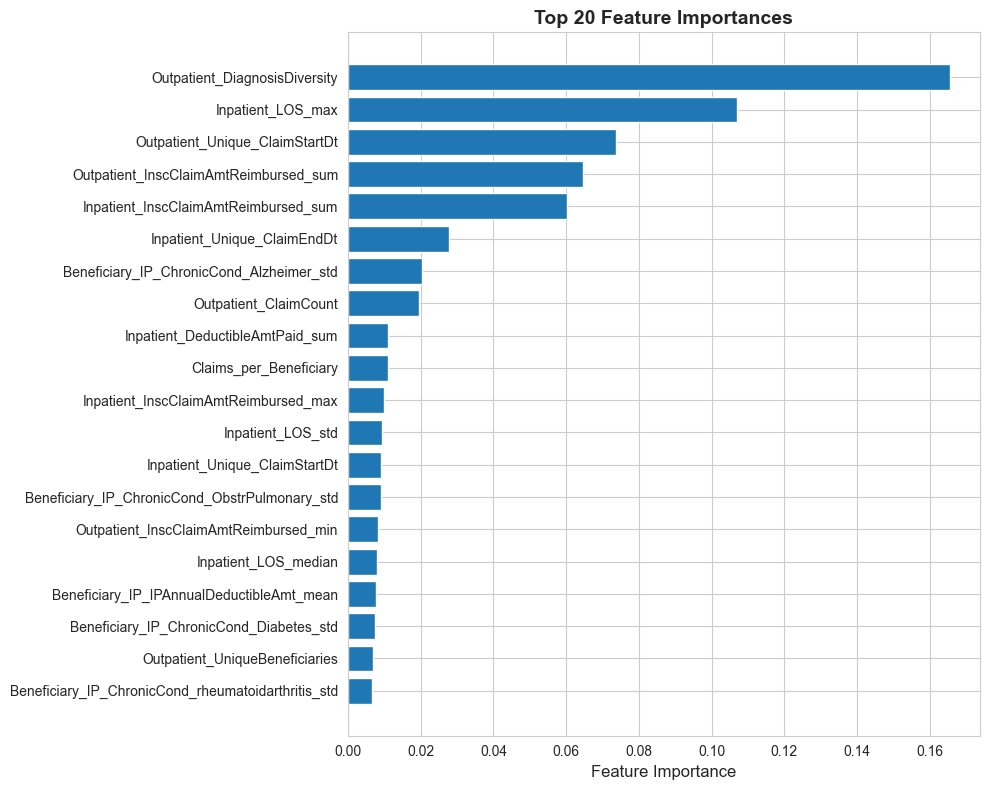

In [14]:
# Extract feature importance if available
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("=" * 60)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("=" * 60)
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualize top features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'].values)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For linear models, use coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', ascending=False, key=abs)
    
    print("=" * 60)
    print("TOP 20 FEATURES BY ABSOLUTE COEFFICIENT")
    print("=" * 60)
    print(feature_importance.head(20).to_string(index=False))
else:
    print("Feature importance not available for this model type.")


## 10. Summary and Recommendations


In [15]:
print("=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)

print(f"\nModel Performance on Test Set:")
print(f"  Precision: {precision:.4f} - {precision*100:.2f}% of flagged providers are actually fraudulent")
print(f"  Recall:    {recall:.4f} - {recall*100:.2f}% of fraudulent providers are detected")
print(f"  F1-Score:  {f1:.4f} - Balanced measure of precision and recall")
print(f"  ROC-AUC:   {roc_auc:.4f} - Ability to distinguish between classes")
print(f"  PR-AUC:    {pr_auc:.4f} - Performance on imbalanced data")

print(f"\nError Analysis:")
print(f"  False Positives: {fp} - Legitimate providers incorrectly flagged")
print(f"  False Negatives: {fn} - Fraudulent providers missed")

print(f"\nKey Findings:")
print(f"  1. The model achieves a balance between precision and recall")
print(f"  2. False positives may occur when legitimate providers have unusual patterns")
print(f"  3. False negatives may indicate sophisticated fraud schemes")
print(f"  4. Additional features or domain expertise may help reduce errors")

print(f"\nRecommendations:")
print(f"  1. Consider adjusting classification threshold based on business priorities")
print(f"  2. Implement a review process for high-probability cases before investigation")
print(f"  3. Collect additional features that may help distinguish edge cases")
print(f"  4. Regular model retraining as fraud patterns evolve")
print(f"  5. Incorporate domain expert feedback for complex cases")


EVALUATION SUMMARY

Model Performance on Test Set:
  Precision: 0.6379 - 63.79% of flagged providers are actually fraudulent
  Recall:    0.7327 - 73.27% of fraudulent providers are detected
  F1-Score:  0.6820 - Balanced measure of precision and recall
  ROC-AUC:   0.9679 - Ability to distinguish between classes
  PR-AUC:    0.7989 - Performance on imbalanced data

Error Analysis:
  False Positives: 42 - Legitimate providers incorrectly flagged
  False Negatives: 27 - Fraudulent providers missed

Key Findings:
  1. The model achieves a balance between precision and recall
  2. False positives may occur when legitimate providers have unusual patterns
  3. False negatives may indicate sophisticated fraud schemes
  4. Additional features or domain expertise may help reduce errors

Recommendations:
  1. Consider adjusting classification threshold based on business priorities
  2. Implement a review process for high-probability cases before investigation
  3. Collect additional features th

## Summary

This notebook has:
1. ✅ Evaluated the best model on the test set
2. ✅ Calculated comprehensive metrics (Precision, Recall, F1, ROC-AUC, PR-AUC)
3. ✅ Created confusion matrix visualizations
4. ✅ Generated ROC and Precision-Recall curves
5. ✅ Conducted cost-based analysis
6. ✅ Analyzed false positives and false negatives
7. ✅ Created case studies for 2-3 false positives and 2-3 false negatives
8. ✅ Examined feature importance
9. ✅ Provided recommendations for improvement

The evaluation is complete and ready for reporting!
